<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/CNN_mnist-SVM_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Network (CNN)

Classification of handwritten numbers (MNIST) by CNN

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [18]:
# load MNIST data
train_Dataset = dsets.MNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.MNIST(
      root='./data',
      train=False,
      transform=transforms.ToTensor(),
      download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [48000, 12000])  # 分割数

print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))
print('test_dataset = ', len(test_dataset))


train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


In [19]:
# set data loader
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=64,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=64,
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=64,
      shuffle=False,
      num_workers=2)


In [20]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)

cpu
Network architecture for CNN
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [21]:
class HingeLoss(torch.nn.Module):

    def __init__(self):
        super(HingeLoss, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, output, target):
        one_hot_target = nn.functional.one_hot(target, num_classes=10)
#        print(one_hot_target.shape)
#        print(output.shape)
        all_ones = torch.ones_like(one_hot_target)
#        print(all_ones.shape)
        labels = 2 * one_hot_target - all_ones
#        print(labels.shape)
#        print(output.squeeze(1).shape)
        losses = all_ones - torch.mul(output.squeeze(1), labels)

        return torch.norm(self.relu(losses))

In [22]:
# optimizing
#criterion = nn.CrossEntropyLoss()
criterion = HingeLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
#optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)


In [23]:
###  training
print ('training start ...')
num_epochs = 10

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
#        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation
        optimizer.step()  # optimization

    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)

    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...
Epoch [1/10] train Loss: 0.0544, train acc: 0.9760 | val_loss: 0.0552, val_acc: 0.9729
Epoch [2/10] train Loss: 0.0406, train acc: 0.9852 | val_loss: 0.0441, val_acc: 0.9828
Epoch [3/10] train Loss: 0.0296, train acc: 0.9920 | val_loss: 0.0339, val_acc: 0.9885
Epoch [4/10] train Loss: 0.0290, train acc: 0.9921 | val_loss: 0.0349, val_acc: 0.9882
Epoch [5/10] train Loss: 0.0252, train acc: 0.9939 | val_loss: 0.0325, val_acc: 0.9894
Epoch [6/10] train Loss: 0.0277, train acc: 0.9927 | val_loss: 0.0355, val_acc: 0.9887
Epoch [7/10] train Loss: 0.0272, train acc: 0.9931 | val_loss: 0.0368, val_acc: 0.9873
Epoch [8/10] train Loss: 0.0280, train acc: 0.9925 | val_loss: 0.0378, val_acc: 0.9880
Epoch [9/10] train Loss: 0.0177, train acc: 0.9965 | val_loss: 0.0314, val_acc: 0.9904
Epoch [10/10] train Loss: 0.0162, train acc: 0.9975 | val_loss: 0.0296, val_acc: 0.9912


In [24]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total))

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 99.24 %


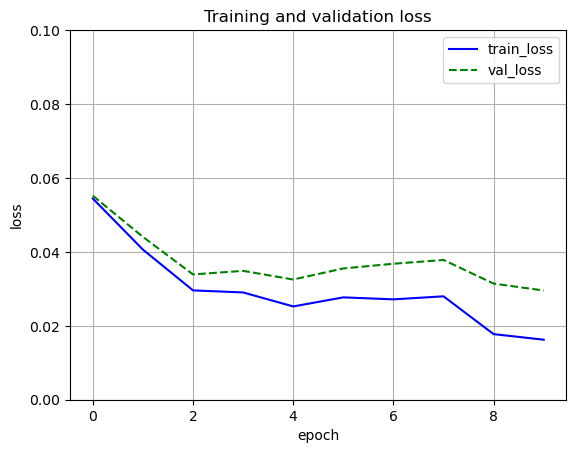

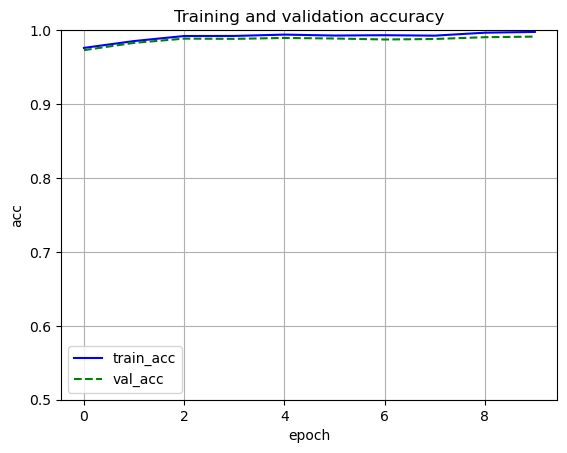

In [25]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.1])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('CNN_mnist-SVM__loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('CNN_mnist-SVM__acc.png')
plt.show()